In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
%matplotlib inline

In [3]:
class Node(object):
    def __init__(self,value,is_leaf=False):
        self.value = value
        self.left = None
        self.right = None
        self.gini_value = None
        self.col_index = None
        self.is_leaf = is_leaf

In [4]:
class decision_tree_classifier(object):
    def __init__(self, min_samples=5, min_gini=0.0, max_depth=10):
        self.root = None
        self.min_samples = min_samples
        self.min_gini = min_gini
        self.max_depth = max_depth
        self.classes = None
    
    def fit(self,data):
        self.classes = list(set(int(row[-1]) for row in data))
        self.root = self.create_node(data) 
        self.build_tree(self.root,current_depth = 0)
        return self.root
    
    def create_node(self,data):
        node = Node(None)
        
        ### checking if node can be further split using minimum gini as criterion
        gini_score = self.gini_index(data)
        if gini_score <= self.min_gini:
            node.is_leaf = True
            node.value = np.bincount([row[-1] for row in data]).argmax()
            node.gini_value = gini_score
            return node
        
        ### checking if node has enough samples to be split again 
        if len(data) <= self.min_samples:
            node.is_leaf = True
            node.value = np.bincount([row[-1] for row in data]).argmax()
            node.gini_value = gini_score
            return node

        ### finding minimum gini impurity split 
        gini_index = 1.0
        for col_index in range(len(data[0])-1):
            for row_index in range(len(data)):
                value = data[row_index][col_index]
                child = self.get_split(data,col_index,value)
                node_gini_index = self.calculate_gini_index(value,child)
                if node_gini_index < gini_index:
                    gini_index = node_gini_index
                    node.value = value
                    node.gini_value = node_gini_index
                    node.col_index = col_index
                    node.left = child['l']
                    node.right = child['r']
        return node
    
    def gini_index(self,data):
        size = len(data)
        instances = [0] * len(self.classes)
        for row in data:
            instances[int(row[-1])] += 1
        return 1 - np.sum([(val/size)**2 for val in instances]) if size > 0 else 1

    def calculate_gini_index(self,value,child):
        group_size = [len(child['l']),len(child['r'])] 
        left_gini = self.gini_index(child['l'])
        right_gini =  self.gini_index(child['r'])
        return (group_size[0]/np.sum(group_size) * left_gini) + (group_size[1]/np.sum(group_size) * right_gini)

    def get_split(self,data,col_index,value):
        left_child, right_child = [], []
        for index in range(len(data)):
            if data[index][col_index] < value:
                left_child.append(data[index])
            if data[index][col_index] > value:
                right_child.append(data[index])
        return {'l':left_child, 'r':right_child}

    def build_tree(self,node,current_depth):
        ## create left subtree for the node if possible under constraints
        if  current_depth < self.max_depth:
            ## creating left node 
            if node.left is not None and isinstance(node.left,list):
                left_node = self.create_node(node.left)
                node.left = left_node
                if node.left.is_leaf is not True:
                    self.build_tree(node.left,current_depth+1)
            if node.right is not None and isinstance(node.right,list):
            ## creating right node
                right_node = self.create_node(node.right)
                node.right = right_node
                if node.right.is_leaf is not True:
                    self.build_tree(node.right,current_depth+1)
                    
    def traverse(self):
        tree = {'root':str(self.root.value)}
        stack = [self.root]
        node = self.root
        while len(stack) > 0:
            while node is not None:
                stack.append(node)
                node = node.left            
            node = stack.pop(-1)
            if node.is_leaf is not True:
                tree[str(node.value)] = {'left':node.left.value,'right':node.right.value,'feature':node.col_index,'gini value':node.gini_value}
            else:
                tree[str(node.value)] = {'left':'None','right':'None','class label':node.value,'gini value':node.gini_value,'leaf':True}
            node = node.right
        return tree

    def predict(self,sample):
        predictions = []
        for row in sample:
            node = self.root
            while node.is_leaf is not True:
                if row[node.col_index] < node.value:
                    node = node.left
                    continue
                if row[node.col_index] >= node.value:
                    node = node.right
            predictions.append(node.value)
        return predictions

In [5]:
def accuracy(data):
    dt = decision_tree_classifier()
    tree = dt.fit(data)
    print('<========= decision tree ===========>')
    print(dt.traverse())
    random = np.random.randint(0,len(data),size=len(data)//5)
    predictions, true_values = dt.predict(data[random]), [data[i][-1] for i in random]
    return '{:1f}'.format(sum([t==p for t,p in zip(true_values, predictions)])/len(true_values) *100 ) + '% accuracy' 

In [6]:
def flower_to_id(value):
    if value == 'Iris-virginica':
        return 2
    if value == 'Iris-versicolor':
        return 0
    if value == 'Iris-setosa':
        return 1

In [7]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
values = requests.get(url).content.decode('utf-8').split('\n')
data_set = [val.split(',') for val in values]
data_df = pd.DataFrame(data=data_set,columns=['sepal_length','sepal_width','petal_length','petal_width','flower'])
data_df = data_df.dropna()
data_df[['sepal_length','sepal_width','petal_length','petal_width']] = data_df[['sepal_length','sepal_width','petal_length','petal_width']].astype('float')

data_df

,sepal_length,sepal_width,petal_length,petal_width,flower
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


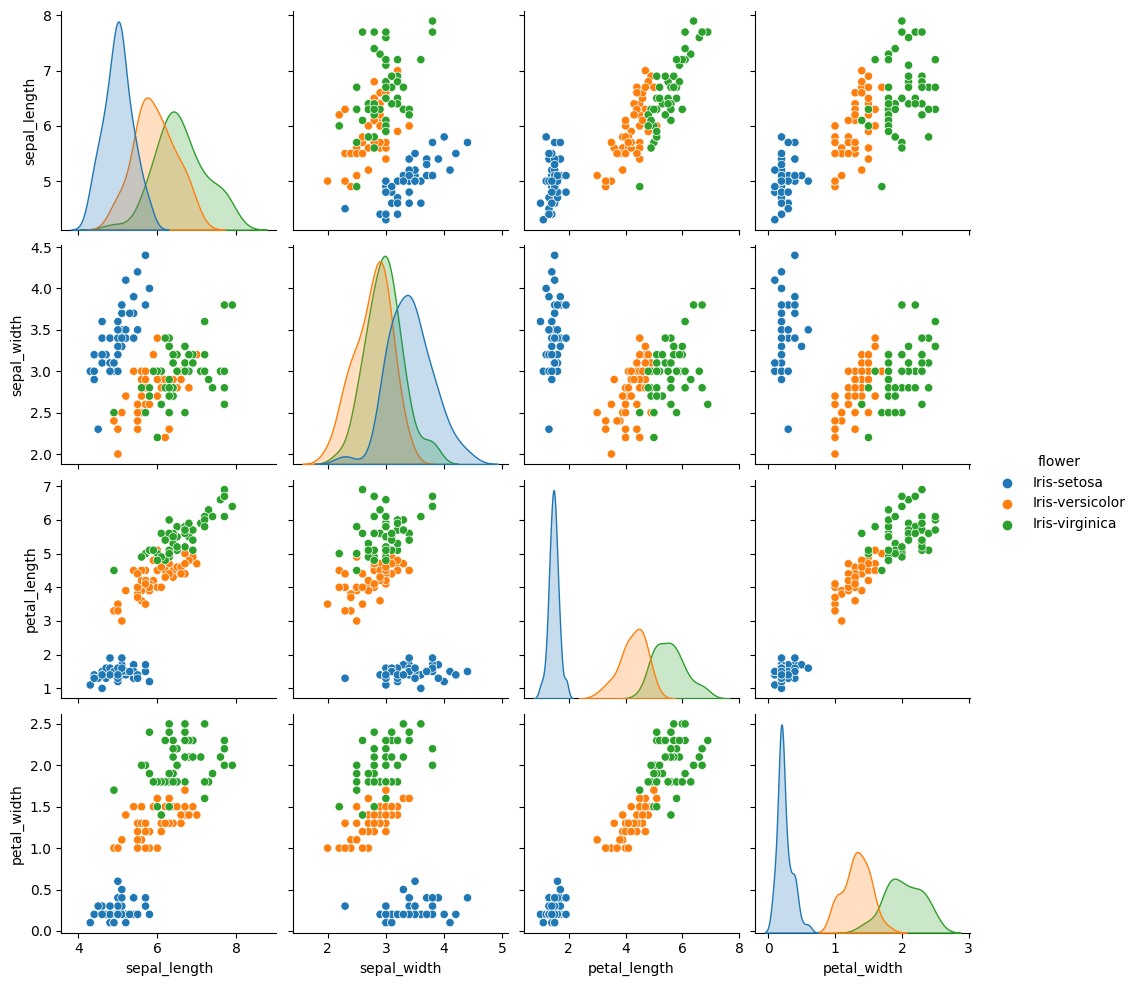

In [8]:
sns.pairplot(data=data_df, hue='flower')

In [9]:
# sns.heatmap(data_df.corr())

In [10]:
data_df['flower'] = data_df['flower'].map(flower_to_id)
print(accuracy(data_df.to_numpy()))

<========= decision tree ===========>
{'root': '1.0', '1': {'left': 'None', 'right': 'None', 'class label': 1, 'gini value': 0.0, 'leaf': True}, '1.0': {'left': 1, 'right': 1.7, 'feature': 3, 'gini value': 0.32333258139709753}, '0': {'left': 'None', 'right': 'None', 'class label': 0, 'gini value': 0.0, 'leaf': True}, '5.0': {'left': 0, 'right': 2, 'feature': 2, 'gini value': 0.03409090909090909}, '2': {'left': 'None', 'right': 'None', 'class label': 2, 'gini value': 0.0, 'leaf': True}, '1.7': {'left': 5.0, 'right': 5.9, 'feature': 3, 'gini value': 0.10159791898922337}, '5.9': {'left': 2, 'right': 2, 'feature': 0, 'gini value': 0.0}}
100.000000% accuracy


In [11]:
from sklearn.model_selection import train_test_split

target = data_df['flower']
df = data_df.copy()
df = df.drop('flower', axis=1)
X_train, X_test, y_train, y_test = train_test_split(df , target, test_size = 0.2, random_state = 42)

print("Training split input- ", X_train.shape)
print("Testing split input- ", X_test.shape)

Training split input-  (120, 4)
Testing split input-  (30, 4)


In [12]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix

dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

y_pred = dtree.predict(X_test)
print("Classification report - \n", classification_report(y_test,y_pred))

Classification report - 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



Text(0.5, 1.0, 'Accuracy Score: 1.0')

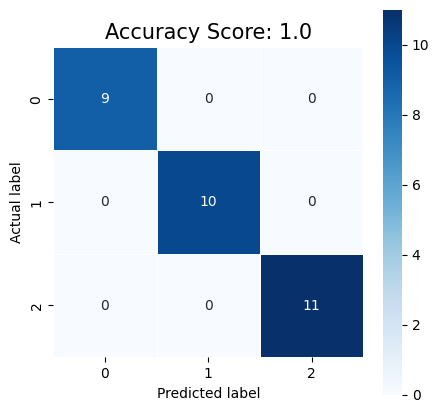

In [13]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))

sns.heatmap(data=cm, linewidths=.5, annot=True, square = True,  cmap = 'Blues')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')

all_sample_title = 'Accuracy Score: {0}'.format(dtree.score(X_test, y_test))
plt.title(all_sample_title, size = 15)

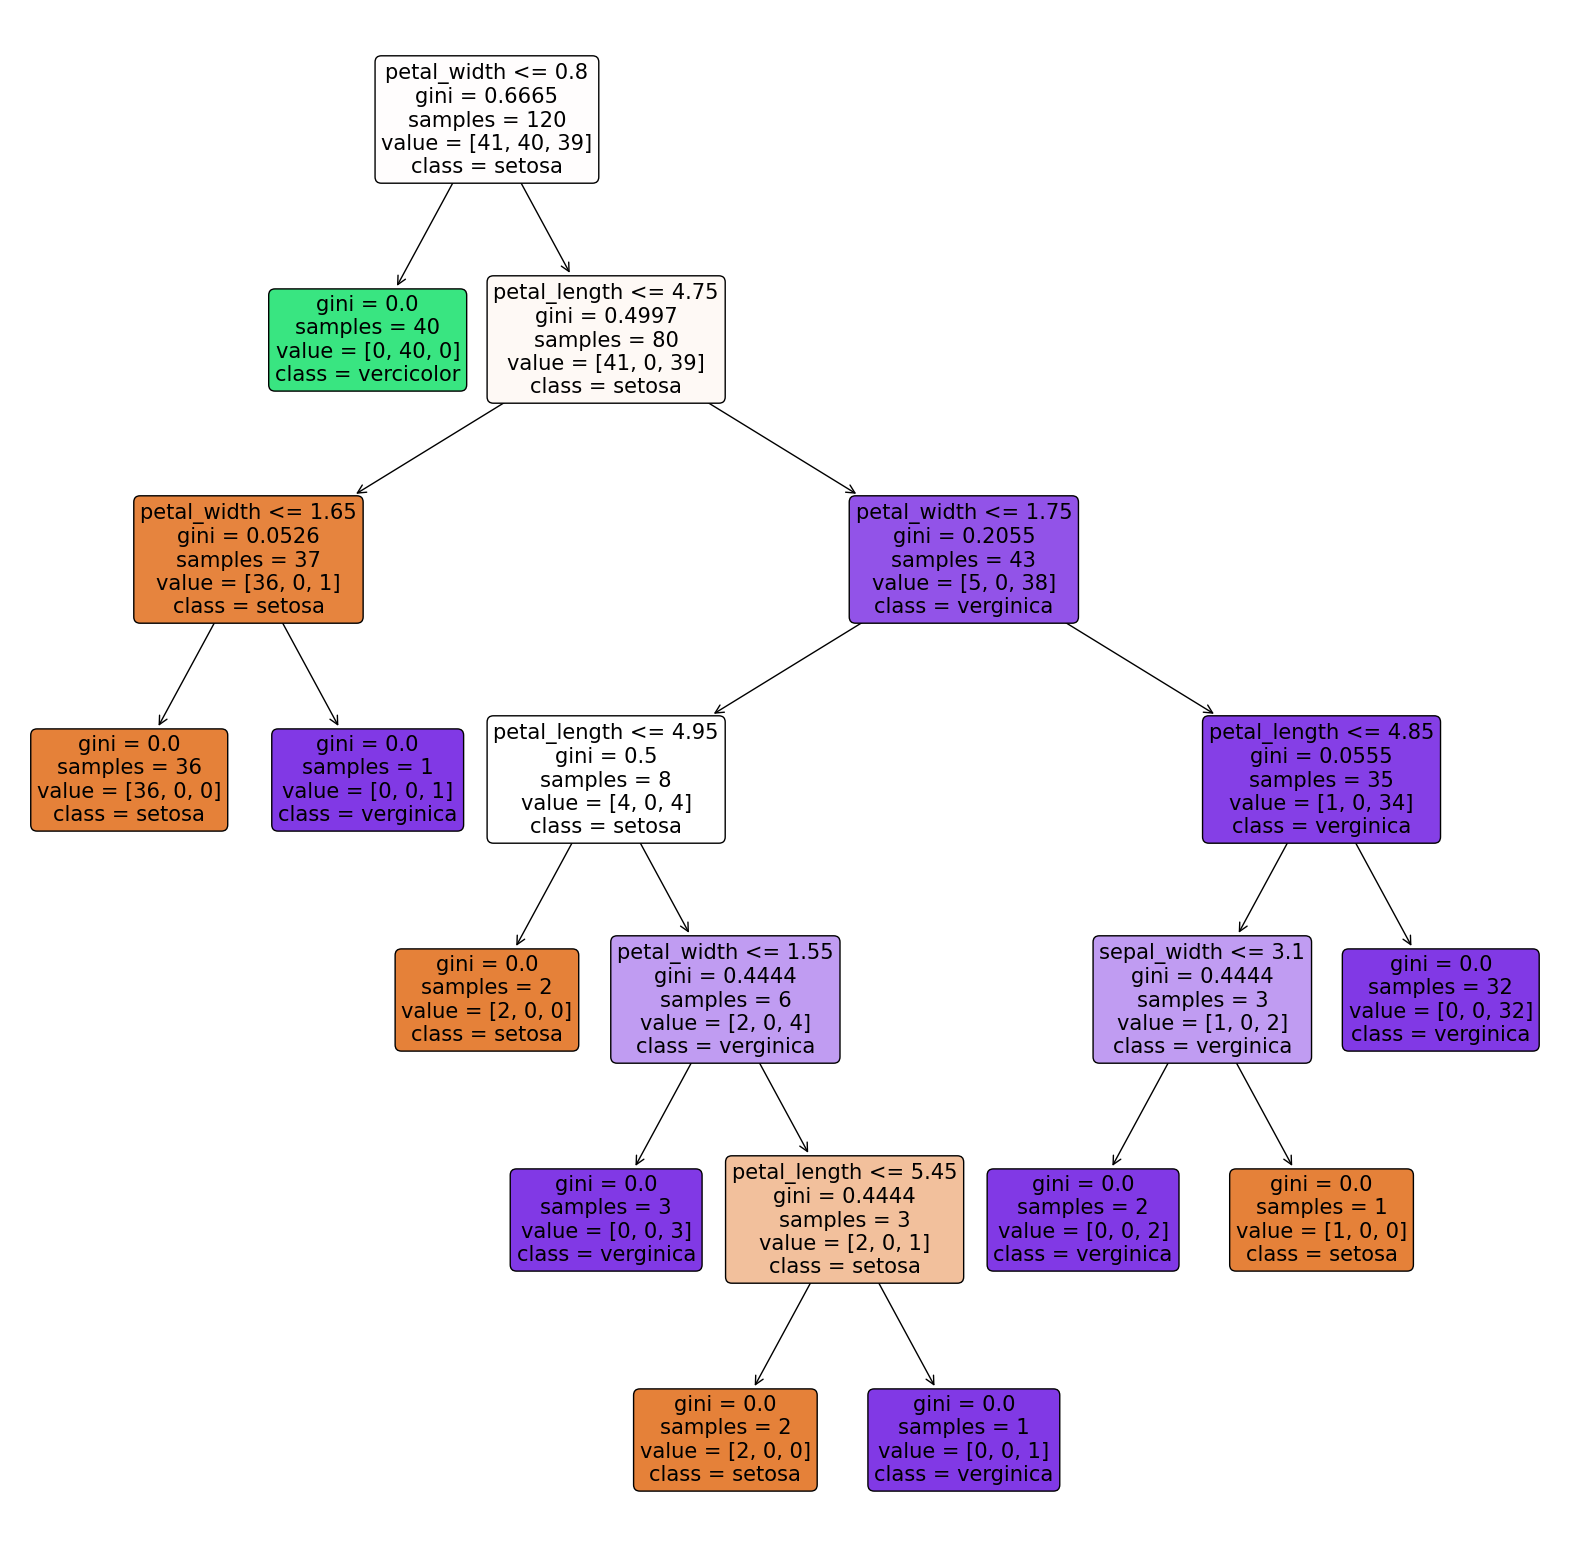

In [14]:
plt.figure(figsize = (20,20))
dec_tree = plot_tree(decision_tree=dtree, feature_names = df.columns, 
                     class_names =["setosa", "vercicolor", "verginica"] , filled = True , precision = 4, rounded = True)